<a href="https://colab.research.google.com/github/adeepH/OLD-Shared-Task/blob/main/Bert%2BbiLSTM_Kannada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 4.1MB/s 
     |████████████████████████████████| 3.0MB 16.3MB/s 
     |████████████████████████████████| 1.1MB 53.2MB/s 
     |████████████████████████████████| 890kB 56.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=47b70bab4fe17d25b86c8989ac6d90956766f22b5644f4fda0edb1a0d6ebd663
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/kannada_offensive_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

tweets  labels
0     Tik tok alli jagala madtidralla adra baggenu o...       0
1                               Anyone from kerala here       5
2                             Movie rerelease madi plss       0
3     Amazon prime alli bittidira....yella manele no...       0
4     Guru sure news nanu tik tok dawn lod madeda ya...       0
...                                                 ...     ...
6212                @Gajendra hv neen en maadirodu mele       2
6213                       Sir neev adthidda game yavdu       0
6214                          Dubb Full movie in telugu       0
6215  Mostly nimma mate keli tic tok ban agirbeku ಅಣ...       0
6216  Sir Nimm Mathininda Navu Kalibeku Agirodu Ennu...       0

[6217 rows x 2 columns]

In [3]:
val=pd.read_csv('/content/kannada_offensive_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

tweets  labels
0                                       100 days pakka       0
1                                            Super sir       5
2                                             Hands up       5
3    Sari nivu video na roast madi adre madvaga pub...       0
4                         Krishana  shapa tatteleebeku       0
..                                                 ...     ...
772  Nanu kuda direction course kalita iddene...nim...       0
773                     Ninige bere kelsa ilvaa madoke       2
774                           മലയാളീസ് ഹാൻഡ്‌സ് അപ്പ്‌       5
775  ದರ್ಶನ್ ಅಭಿಮಾನಿಗಳ ಕಡೆಯಿಂದ ಆಲ್ ದ ಬೆಸ್ಟ್ ಆಲ್ ದ ಬೆ...       0
776                                  ಕಥೆಯಲ್ಲಿ ದಮ್ ಇಲ್ಲ       1

[777 rows x 2 columns]

In [4]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [5]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (6217, 2)
validation set size: (777, 2)


In [6]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([0.29237208, 3.14944276, 2.12765229, 8.42411924, 4.88757862,
       0.68079282])

In [7]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [8]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [9]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [10]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [17]:
model = RFClassifier(5)
model = model.to(device)

In [18]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 1m 32s
Train Loss 1.2993355894700074 accuracy 0.6433971368827409
Val Loss 0.9663606739044189 accuracy 0.7014157014157014

Epoch: 02 | Epoch Time: 1m 31s
Train Loss 0.8428364055278974 accuracy 0.7257519704037317
Val Loss 0.8817067980766297 accuracy 0.7361647361647361

Epoch: 03 | Epoch Time: 1m 32s
Train Loss 0.7138074518778386 accuracy 0.7712723178381856
Val Loss 0.8659664511680603 accuracy 0.7078507078507078

Epoch: 04 | Epoch Time: 1m 32s
Train Loss 0.6186477665717786 accuracy 0.8079459546405019
Val Loss 0.8576683640480042 accuracy 0.7297297297297297

Epoch: 05 | Epoch Time: 1m 32s
Train Loss 0.5219390018628194 accuracy 0.8357728808106805
Val Loss 0.8975873851776123 accuracy 0.7142857142857143

Epoch: 06 | Epoch Time: 1m 32s
Train Loss 0.4541963223081369 accuracy 0.8541096992118385
Val Loss 0.9651860237121582 accuracy 0.6988416988416988

Epoch: 07 | Epoch Time: 1m 32s
Train Loss 0.41365976295410056 accuracy 0.8674601898021554
Val Loss 0.971894781589508 accurac

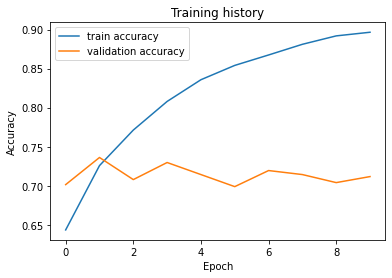

In [23]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [24]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.7117117117117117

In [25]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [26]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [29]:
class_name=['Not_offensive',
'not-Kannada',
'Offensive_Targeted_Insult_Individual',
'Offensive_Targeted_Insult_Group',          
'Offensive_Untargetede',                    
'Offensive_Targeted_Insult_Other']

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.82      0.80       426
                         not-Kannada       0.24      0.36      0.28        45
Offensive_Targeted_Insult_Individual       0.71      0.56      0.63        66
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        16
               Offensive_Untargetede       0.09      0.06      0.07        33
     Offensive_Targeted_Insult_Other       0.80      0.77      0.78       191

                            accuracy                           0.71       777
                           macro avg       0.44      0.43      0.43       777
                        weighted avg       0.70      0.71      0.70       777



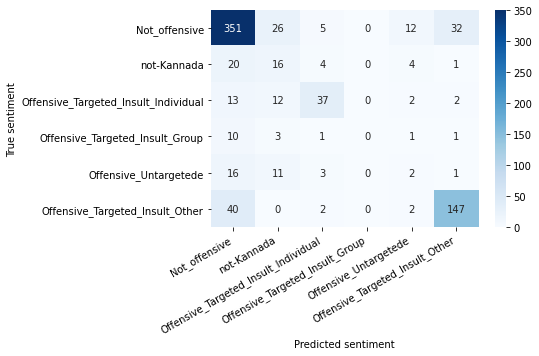

In [31]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)